In [1]:
%pylab --no-import-all
%matplotlib inline
import sacla
import idi.reconstruction as recon
import idi.util as util


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
l=sacla.log('2019 SACLA - Shotlog.csv')
import pandas as pd
pd.set_option('display.max_rows', 1000)
l

,Run start,last run,Starttime,Endtime,Sample,E_ph,Pre Comment,Pulse Energy,Detector Filter,Beamline filter,...,Sx speed,Sz min,Sz max,Sz spacing,Single_x,Single_y,Single_z,Prof_Y,Prof_X2,Prof_Z1
,#,#,Time,Time,#/desc,keV,desc,uJ,desc,mm Silicon,...,pulse/sec,pulses,pulses,pulses,microns,microns,microns,microns,microns,microns
0,781931,NaN,05:47:29,NaN,1,10.4,NaN,562.0,50um Zink,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,781932,781952.0,09:20:14,09:29:08,15,10.4,background,570.0,50um Zink,0.4,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
2,781953,781959.0,09:30:16,09:31:57,15,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
3,781960,781965.0,09:35:57,09:31:57,15,10.4,NaN,570.0,50um Zink,0.4,...,3600.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
4,781966,781975.0,09:39:18,09:42:37,15,10.4,NaN,570.0,50um Zink,0.5,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
5,781976,781985.0,09:50:41,09:42:37,22x17 empty,10.4,empty 22x17 window,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
6,781976,781985.0,09:50:41,09:42:37,none,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
7,781976,781985.0,09:50:41,09:42:37,none,10.4,Stephan shielded from air scattering after tar...,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
8,781976,781985.0,09:50:41,09:42:37,none,10.4,Tais shieded detector from upstream,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN


In [3]:
from funchelper import *
import scipy.ndimage as snd
import os, shutil
import datetime
from idi.util import accumulator

def isdir(string):
    if os.path.isdir(string):
        return os.path.abspath(string)
    else:
        raise NotADirectoryError(string)

def isfile(string):
    if os.path.isfile(string):
        return os.path.abspath(string)
    else:
        raise FileNotFoundError(string)

def diffdist(*args):
    accum = 0
    for arg in args:
        accum += np.diff(arg) ** 2
    return np.sqrt(accum)

def intensities(detector):
    @asgen
    def intensity(img):
        return np.sum(img)

    return detector.absolute_gain * 3.65 * np.array(list(intensity(detector)))

def getbg(detector):
    accum = accumulator()
    for img in detector:
        dat = np.array(img) * detector.absolute_gain * 3.65
        hits = dat > 2000
        empty = ~(snd.morphology.binary_dilation(hits, snd.morphology.generate_binary_structure(2, 2)))
        accum.add(dat * empty.astype(float), empty)
    return accum.mean

def photonize(img, energy, gain=1, bg=0):
    return np.rint(((np.squeeze(np.array(img)) * gain * 3.65) - bg) / energy)

def photonsstats(detector, bg, energy, thres=10):
    accum = accumulator()
    photonsum = []
    maxphotons = 0
    for n, img in enumerate(detector):

        photons = photonize(img, energy, detector.absolute_gain, bg)
        ps = np.sum(photons)
        if ps > thres:
            accum.add(photons)
            maxphotons = np.maximum(maxphotons, photons)
        photonsum.append(ps)
    return (accum.mean, accum.std, maxphotons, np.array(photonsum))

In [4]:
inputfile=isfile('/UserData/gorkhover/TAIS2019/%i.h5'%782182)
detectorname='detector_2d_1'
energy =  9250
nmax = np.inf
z = (4 * 1e-2) / (50 * 1e-6)

In [5]:
run = sacla.saclarun(inputfile, settings=sacla.Tais2019)
print(f'{len(run)} images in input')
detector = getattr(run, detectorname)
print('init done', flush=True)

5000 images in input
init done


In [6]:
# filter by distance between shots
setdist = np.percentile(diffdist(run.sampleX), 75)
mindist = setdist * 0.7
distok = np.concatenate(([0], diffdist(run.sampleX, run.sampleZ))) > mindist
shots = run[distok]
detector = getattr(shots, detectorname)
print(f'distance done, {len(shots)} remaining')

distance done, 4301 remaining


In [7]:
#background
bg = getbg(detector)
print('background done', flush=True)

background done


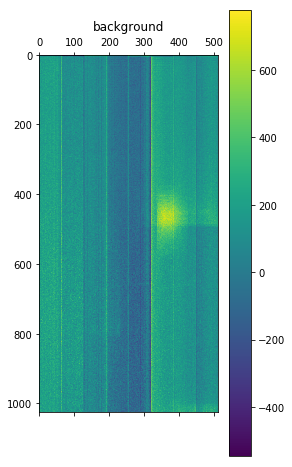

In [8]:
plt.matshow(bg)
plt.title('background')
plt.colorbar()
plt.show()

In [9]:
mask=bg>0
bg2=bg-np.mean(bg)
bg2=bg2/np.std(bg)
t=recon.simple.corr(bg2)
norm=recon.simple.corr(mask)
t2=t/norm

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


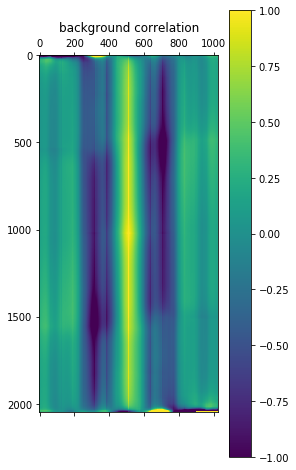

In [10]:
plt.matshow(t2,vmax=1,vmin=-1)
plt.title('background correlation')
plt.colorbar()
plt.show()

In [12]:
photonsthreshold=500

In [13]:
#photons statistics for filtering
meanphotons, stdphotons, maxphotons, photonsum = photonsstats(detector, bg, energy, photonsthreshold)
intok = photonsum > photonsthreshold
nphotonsmin = np.rint(np.percentile(photonsum[intok], 1))
nphotonsmax = np.rint(np.percentile(photonsum[intok], 99))

intok = np.logical_and.reduce((intok, nphotonsmin < photonsum, photonsum < nphotonsmax))
mask = meanphotons > (0.1 * np.mean(meanphotons))
shots = shots[intok]
detector = getattr(shots, detectorname)
print(f'intensity filter done, keep >{nphotonsmin} && <{nphotonsmax}. {len(shots)} remaining')

#now redo the statistics..
meanphotons2, stdphotons2, maxphotons2, photonsum2 = photonsstats(detector, bg, energy, photonsthreshold)
print(f'statistics done')


intensity filter done, keep >24287.0 && <1072112.0. 4213 remaining
statistics done
start recon...


In [14]:
tmp=bg-np.mean(meanphotons2[mask])
tmp=bg2/np.std(tmp[mask])
t=recon.simple.corr(tmp)
norm=recon.simple.corr(mask)
t2=t/norm


/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


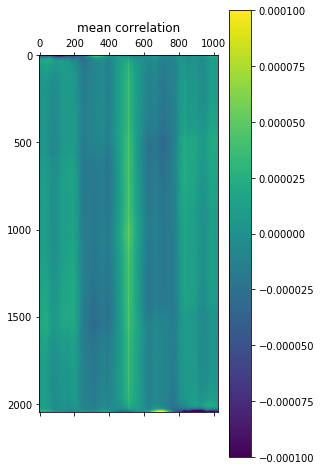

In [15]:
plt.matshow(t2,vmin=-0.0001,vmax=0.0001)
plt.title('mean correlation')
plt.colorbar()
plt.show()

In [106]:
nmax=1000

In [65]:
oldmask=np.copy(mask)

In [66]:
import scipy.ndimage as snd
mask2=~snd.morphology.binary_dilation(~oldmask,snd.morphology.generate_binary_structure(2, 2),iterations=3)
mask2[0,:]=0
mask2[:,0]=0
mask2[-1,:]=0
mask2[:,-1]=0

In [67]:
mask=np.copy(mask2)

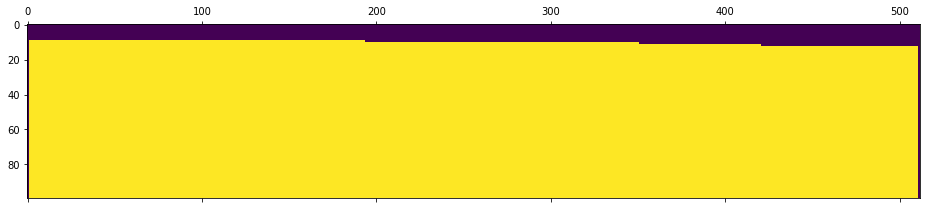

In [68]:
plt.matshow(mask[:100,:])

In [107]:
accum = {'simple': accumulator(), 'ft3d': accumulator(), 'direct': accumulator(), 'directrad': accumulator()}
allimg=[]
alldirectrad=[]
allsimple=[]

shotmean=[]
shotstd=[]
directfunc=None

In [108]:
for n, img in enumerate(detector):
    if n >= nmax:
        break
    photons = photonize(img, energy, detector.absolute_gain, bg) / meanphotons2
    allimg.append(np.array(photons))
    cshotmean=np.mean(photons[mask])
    cshotstd=np.std(photons[mask])
    photons=photons-cshotmean
    photons=photons/cshotstd
    photons[~mask] = 0
    weight=cshotstd**2
    shotmean.append(cshotmean)
    shotstd.append(cshotstd)   
    csimple=recon.simple.corr(photons)
    accum['simple'].add(csimple*weight,weight)
    allsimple.append(csimple)
    accum['ft3d'].add(recon.ft.corr(photons, z)*weight,weight)
    if n == 0:
        for a in accum:
            print(a, accum[a].shape)
    print(n, end=' ',flush=True)


simple (2048, 1024)
ft3d (150, 1000, 1730)
direct 0
directrad 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 26

KeyboardInterrupt: 

In [19]:
mask = meanphotons > (0.1 * np.mean(meanphotons))

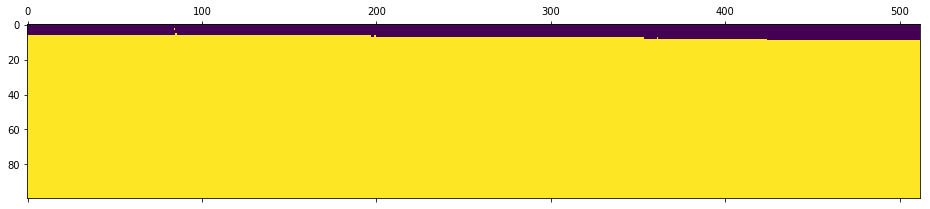

In [39]:
plt.matshow(mask[:100,:])

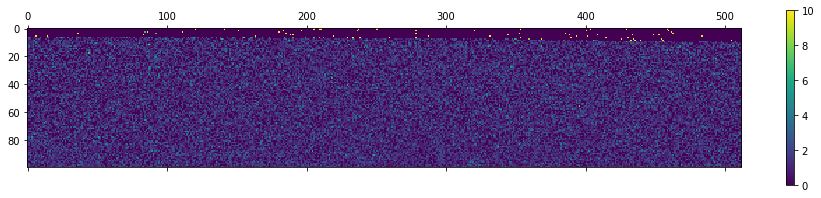

In [89]:
plt.matshow(allimg[0][:100,:],vmax=10)
plt.colorbar()

In [81]:
np.mean(allimg[0])

1.1599563761280671

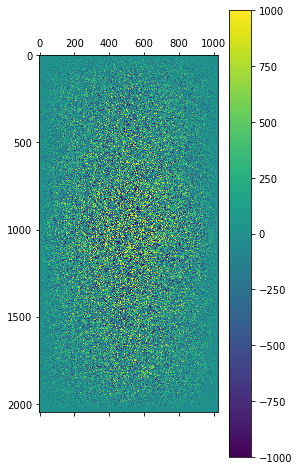

In [90]:
plt.matshow(allsimple[0],vmax=1e3,vmin=-1e3)
plt.colorbar()

In [111]:
plt.rcParams['figure.figsize']=(20,20)

In [194]:
norm=recon.ft.corr(mask,z)
res=accum['ft3d'].mean/norm
res[norm<1e3]=0
res=recon.ft.unwrap(res)


/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


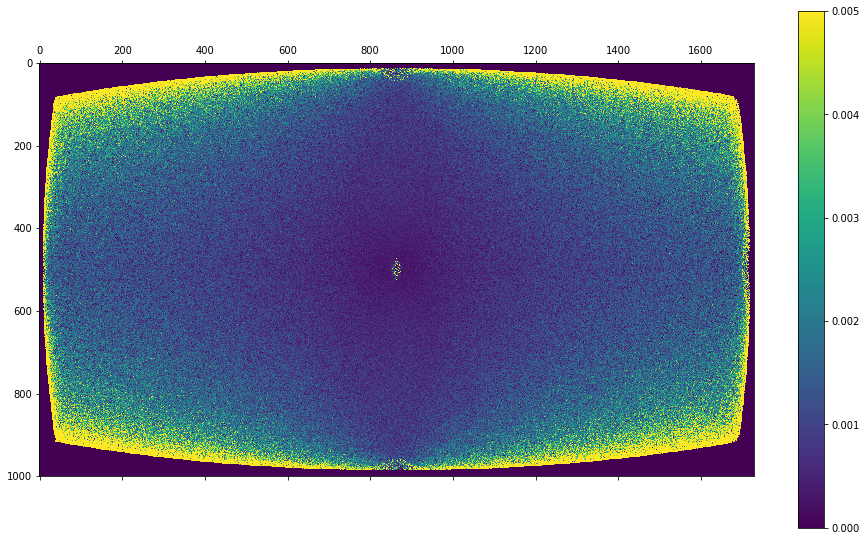

In [200]:
plt.matshow(np.nanmax(res[0:10,...],axis=0),vmin=0,vmax=0.005)
plt.colorbar()

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


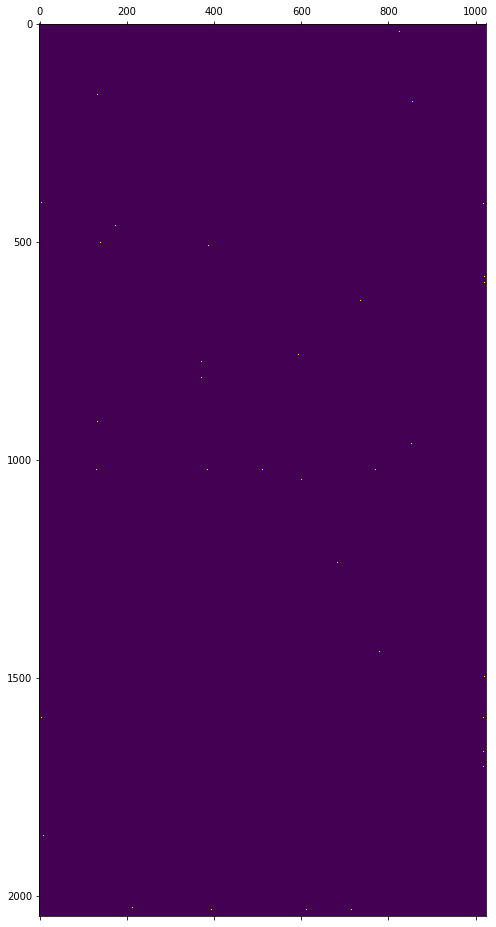

In [189]:
import scipy.signal as _ss
import numpy as _np
def fftfilter_mean(image,size, norm=False):    
    strel=_np.ones(image.ndim*[size])/size**image.ndim
    res=_ss.fftconvolve(image,strel,mode='same')
    if norm: res/=_ss.fftconvolve(_np.ones_like(image),strel,mode='same')
    return res

def fftfilter_std(img,size,sigma):
    image=np.nan_to_num(img)
    norm=fftfilter_mean(_np.ones_like(image),size)
    mean=fftfilter_mean(image,size)/norm
    sqmean=fftfilter_mean(image*image,size)/norm
    std=_np.nan_to_num(_np.sqrt(sqmean-mean*mean))
    res=_np.abs(image-mean)>sigma*std
    res[_np.abs(sigma*std)<1e-15]=0
    return res


In [ ]:
cand=fftfilter_std(res,15,5)
plt.matshow(np.nanmax(cand[:40],axis=0))
plt.show()


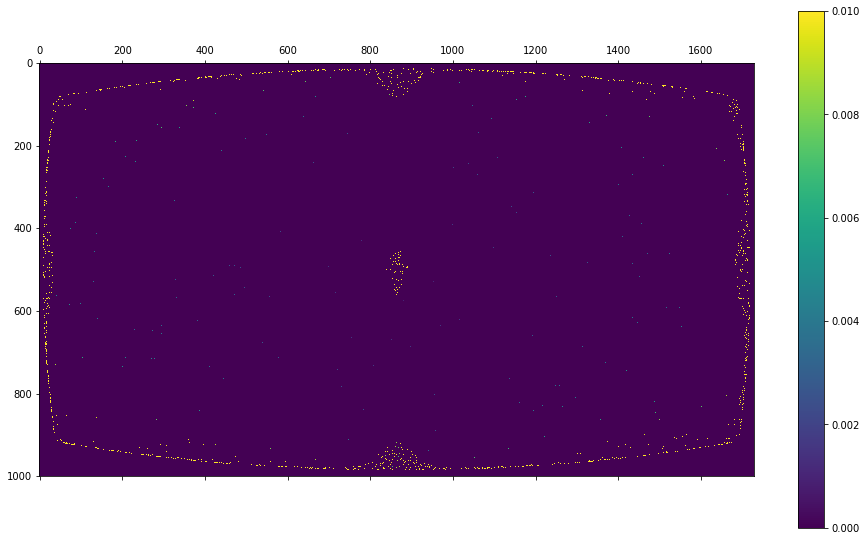

In [234]:
tmp=np.nanmax((cand*res)[0:20,...],axis=0)
tmp=snd.morphology.grey_dilation(tmp,5)

plt.matshow(tmp,vmax=0.01)
plt.colorbar()
plt.show()

In [131]:
res

array([[ 2.83658050e-03, -1.30873726e-03, -1.72260169e-03, ...,
         1.12065258e-03, -1.72260169e-03, -1.30873726e-03],
       [ 2.39918300e-04, -3.38654040e-05, -1.51523199e-04, ...,
         7.13148927e-05, -1.10031960e-05,  3.90631423e-05],
       [-1.91424779e-04, -5.30262907e-04,  3.21172186e-04, ...,
        -6.22574175e-05, -3.23091290e-04,  5.13079600e-04],
       ...,
       [-9.79984386e-05,  1.36079637e-04, -5.59660759e-04, ...,
        -2.75208361e-04,  1.23473316e-04,  1.47376042e-04],
       [-1.91424779e-04,  5.13079600e-04, -3.23091290e-04, ...,
         3.56559769e-04,  3.21172186e-04, -5.30262907e-04],
       [ 2.39918300e-04,  3.90631423e-05, -1.10031960e-05, ...,
        -3.05664582e-04, -1.51523199e-04, -3.38654040e-05]])

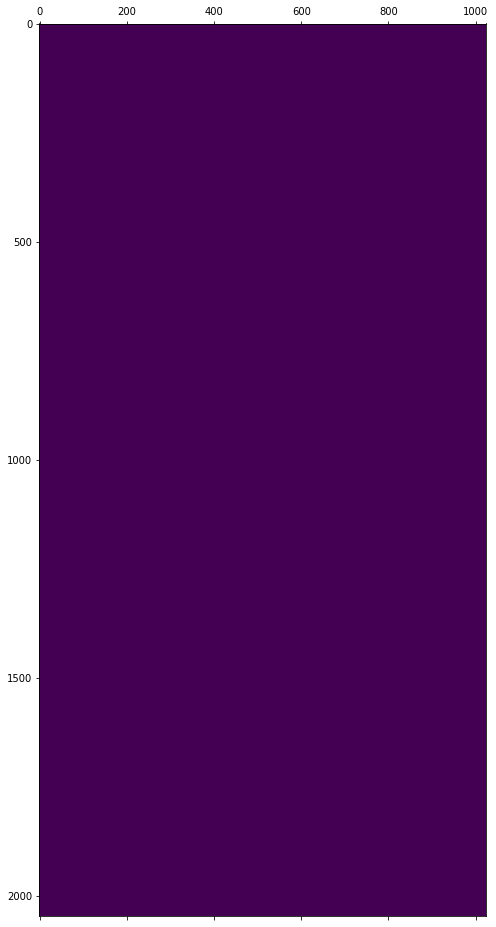

In [124]:
plt.matshow(cand)

In [97]:
np.mean(allsimple,axis=0).shape

(2048, 1024)

In [ ]:

allimg=np.array(allimg)
alldirectrad=np.array(alldirectrad)
allsimplerad=np.array(allsimplerad)
shotstd=np.array(shotstd)
shotmean=np.array(shotmean)

print()
print(f'start saving to {outfile}')
tosave = vars(args)
tosave.update(
    {
        'workfile': workfile,
        'outfile': outfile,
        'mask': mask,
        'meanphotons': meanphotons,
        'stdphotons': stdphotons,
        'maxphotons': maxphotons,
        'nphotonsmax': nphotonsmax,
        'nphotonsmin': nphotonsmin,
        'photonsum': photonsum,
        'bg': bg,
        'mindist': mindist,
        'allimg':allimg,
        'shotmean':shotmean,
        'shotstd':shotstd,
        'Nimg':n,
        'simplerad_all':allsimplerad,
        'directrad_all':alldirectrad
    }
)
tosave.update({f'{k}_mean': v.mean for k, v in accum.items()})
tosave.update({f'{k}_std': v.std for k, v in accum.items()})
np.savez_compressed(outfile, **tosave)

if args.delete:
    print(f'deleting {workfile}', flush=True)
    os.remove(workfile)

print('done!')
